In [1]:

import numpy as np
import healpy as hp
from tqdm import tqdm
import os
from astropy.table import Table
import sys
import time
import pandas as pd
import dustmaps.sfd
#dustmaps.sfd.fetch()

# Custom script imports
#sys.path.append('/Users/mncavieres/Documents/2024-2/HVS/Classify')
from selections import *
from iterative_correction import implied_calculations
from prepare_gaia_iterative import prepare_gaia_iterative, prepare_speedystar
from classifier_CMD import HistogramClassifier2D

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
#main_data_path = '/home/cavierescarreramc/data1'
#output_path = os.path.join(main_data_path, 'candidates_50_v3')
#gaia_catalogs_path = os.path.join(main_data_path, 'gaia_dr3_photometric_uncertainties')
#processed_path = os.path.join(main_data_path, 'gaia_dr3_processed_v2')
simulation_path = '/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long_ready.fits'
prior_path = '/Users/mncavieres/Documents/2024-2/HVS/Classify_ALICE/V2/Prior_map.csv'


In [3]:
speedycatalog = Table.read(simulation_path)
prior = pd.read_csv(prior_path)

In [4]:
"""
Process one Gaia catalog file corresponding to a given HEALPix pixel.
"""
# Load the Gaia catalog
gaia_catalog= Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/candidates/first_run.fits')

# Load the prior map.
# Here we assume the prior map is located in the same folder as the simulation;
# adjust the path as needed.




In [5]:


# Create the color column
gaia_catalog['bp_rp'] = gaia_catalog['phot_bp_mean_mag'] - gaia_catalog['phot_rp_mean_mag']

# Prepare the catalog (e.g., compute implied magnitudes, correct for extinction, etc.)
#gaia_catalog = prepare_gaia_iterative(gaia_catalog)

# Initialize classifier using simulation (speedycatalog) as the training data for HVS
x_hvs = speedycatalog['bp_rp_corr']
y_hvs = speedycatalog['implied_M_g_corr']
x_bg = gaia_catalog['bp_rp_corr']
y_bg = gaia_catalog['implied_M_g_corr']

classifier = HistogramClassifier2D(
    x_hvs, y_hvs, x_bg, y_bg,
    bins_x=100, bins_y=100,
    x_range=(-1.2, 2.5),
    y_range=(-8, 10),
)

In [6]:
# load the testing catalog of speedystar
speedy_test = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/simple_for_proposal/cat_propagated_ejr_3.fits')
speedy_test = prepare_speedystar(speedy_test)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 10/10 [00:00<00:00, 56.61it/s]


In [7]:
# compute the healpix pixel for each source
# Define the HEALPix pixel level and compute the total number of pixels
healpix_level = 4
nside = 2 ** healpix_level
npix = hp.nside2npix(nside)

# ang2pix: Convert angles to pixel numbers
healpix_indices = hp.ang2pix(
    nside, np.radians(90 - speedy_test['dec']), speedy_test['ra'], nest=True
)
speedy_test['healpix'] = healpix_indices

In [9]:
# get the prior pixel for each source based on the healpix pixel
speedy_test['prior'] = prior['prior'].values[speedy_test['healpix']]

In [ ]:


# Classify the catalog sources
p_hvs, p_bg, p_data = classifier.classify(
    speedy_test['bp_rp_corr'],
    speedy_test['implied_M_g_corr'], 
    [0.001]*len(speedy_test),
    [0.001]*len(speedy_test),
)

# Append classification results to the catalog
speedy_test['p_hvs'] = p_hvs
speedy_test['p_background'] = p_bg
speedy_test['p_data'] = p_data
speedy_test['p_hvs_over_bg'] = (p_hvs / p_bg) * speedy_test['prior']
#gaia_catalog['healpix_pixel'] = healpix_pixel




IndexError: index 636 is out of bounds for axis 0 with size 636

In [12]:
import matplotlib.pyplot as plt

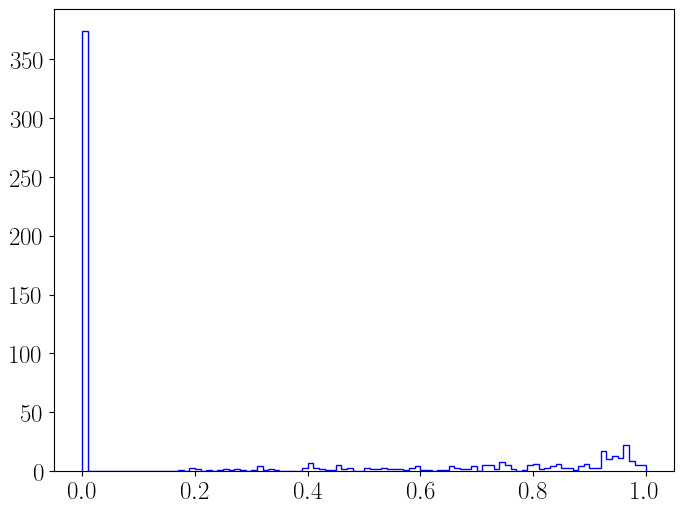

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(p_hvs, bins=100, range=(0, 1), histtype='step', color='blue', label='HVS')
plt.show()

(array([587.,  38.,   3.,   1.,   2.,   1.,   0.,   0.,   0.,   0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

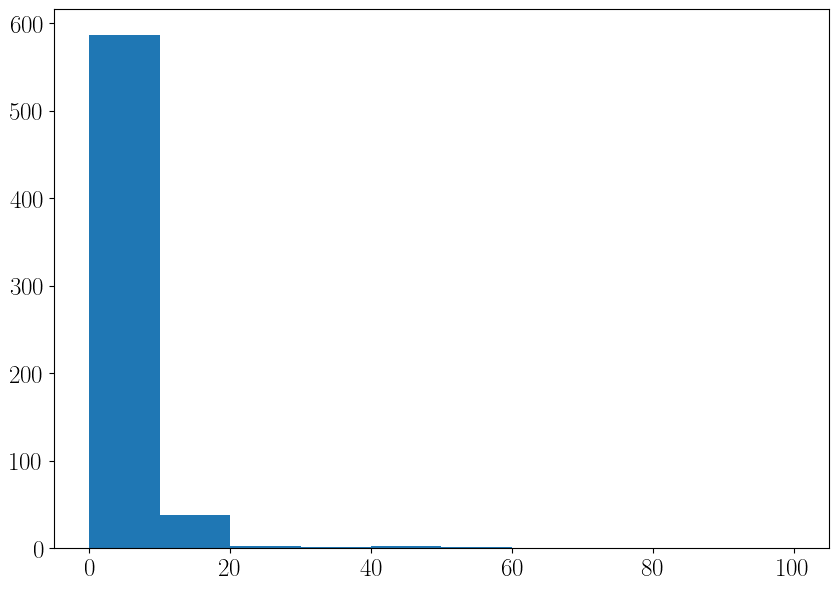

In [27]:
plt.hist(speedy_test['p_hvs_over_bg'], range=(0, 1e2) )

In [35]:

# Convex downward (concave) decreasing function
def f_convex_down(x, a=1e3, c=0, k=0.5):
    return a / (x + c)**k


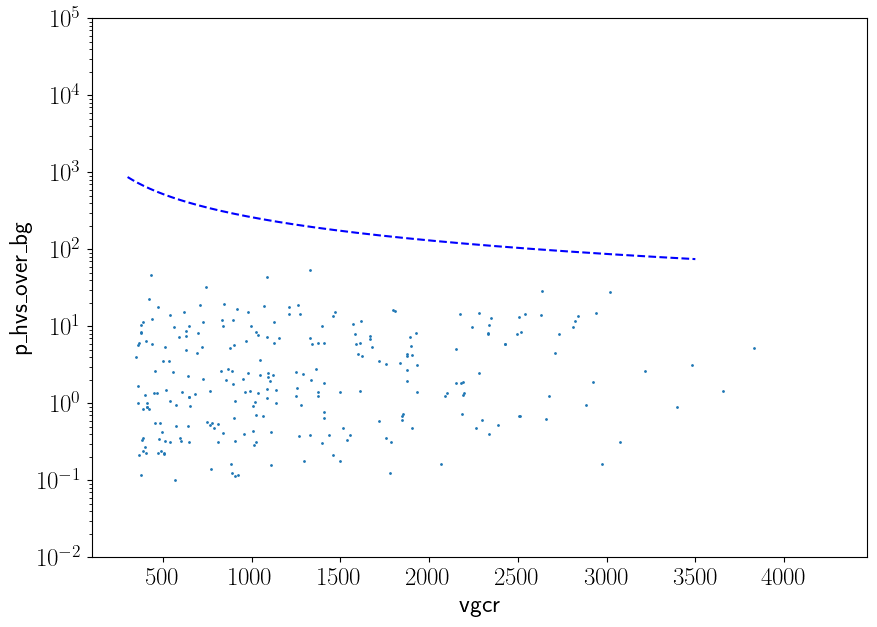

In [39]:
# plot vgcr vs p_hvs_over_bg
# show a linearly decreasing line in logspace
x = np.linspace(300, 3500, 1000)
y =  f_convex_down(x, a=2.6e5, c=0, k=0.999)# + 200
plt.plot(x, y, color='blue', linestyle='--')

plt.scatter(speedy_test['GCv'], speedy_test['p_hvs_over_bg'], s=1)
plt.yscale('log')
plt.ylim(1e-2, 1e5)
plt.xlabel('vgcr')
plt.ylabel('p_hvs_over_bg')
plt.show()

# Now test a larger catalog

We can then scale it up and down for different rates


In [43]:
# ang2pix: Convert angles to pixel numbers
healpix_indices = hp.ang2pix(
    nside, np.radians(90 - speedycatalog['dec']), speedycatalog['ra'], nest=True
)
speedycatalog['healpix'] = healpix_indices

# get the prior pixel for each source based on the healpix pixel
speedycatalog['prior'] = prior['prior'].values[speedycatalog['healpix']]

In [45]:


# Classify the catalog sources
p_hvs, p_bg, p_data = classifier.classify(
    speedycatalog['bp_rp_corr'],
    speedycatalog['implied_M_g_corr'], 
    [0.01]*len(speedycatalog),
    [0.01]*len(speedycatalog),
)

# Append classification results to the catalog
speedycatalog['p_hvs'] = p_hvs
speedycatalog['p_background'] = p_bg
speedycatalog['p_data'] = p_data
speedycatalog['p_hvs_over_bg'] = (p_hvs / p_bg) * speedycatalog['prior']
#gaia_catalog['healpix_pixel'] = healpix_pixel




/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_67112/1802671037.py:13: RuntimeWarning: divide by zero encountered in divide
  speedycatalog['p_hvs_over_bg'] = (p_hvs / p_bg) * speedycatalog['prior']


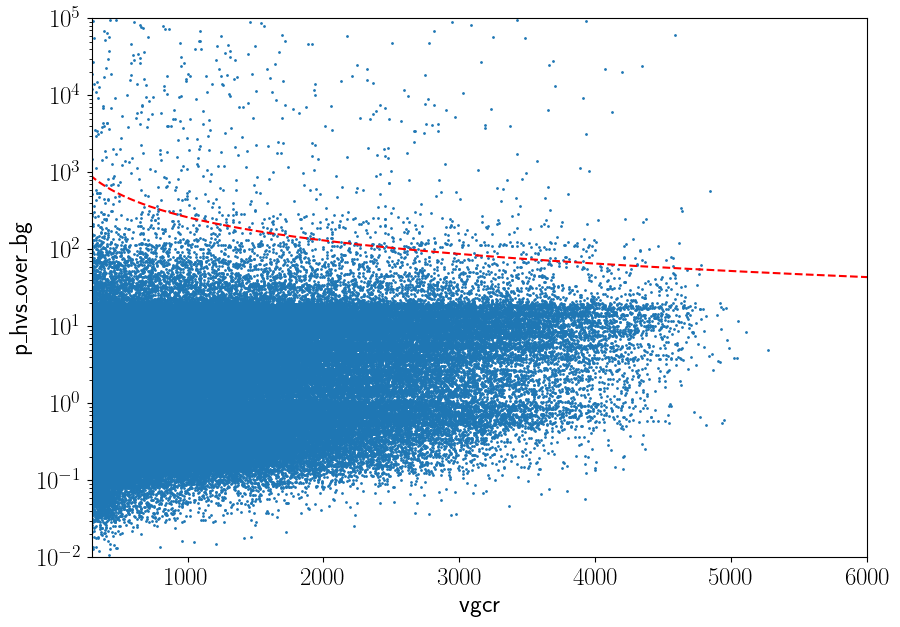

In [50]:
# plot vgcr vs p_hvs_over_bg
# show a linearly decreasing line in logspace
x = np.linspace(10, 6000, 1000)
y =  f_convex_down(x, a=2.6e5, c=0, k=0.999)# + 200
plt.plot(x, y, color='red', linestyle='--')

plt.scatter(speedycatalog['GCv'], speedycatalog['p_hvs_over_bg'], s=1)
plt.yscale('log')
plt.ylim(1e-2, 1e5)
plt.xlabel('vgcr')
plt.ylabel('p_hvs_over_bg')
plt.xlim(300, 6000)
plt.show()

In [56]:
candidates_blue = speedycatalog[speedycatalog['p_hvs_over_bg'] > f_convex_down(speedycatalog['GCv'], a=2.6e5, c=0, k=0.999)]

In [57]:
speedycatalog_red = speedycatalog[speedycatalog['bp_rp_corr'] > 0.5]
candidates_red = speedycatalog_red[speedycatalog_red['p_hvs_over_bg'] > f_convex_down(speedycatalog_red['GCv'], a=1.5e1, c=0, k=0.25)]

In [58]:
print(len(candidates_blue), len(candidates_red))

3178 18100


In [59]:
print('This selection gives ', len(candidates_blue)/len(speedycatalog), ' of the total sample')

This selection gives  0.014058401199697422  of the total sample


In [60]:
print('The red selection gives ', len(candidates_red)/len(speedycatalog_red), ' of the total sample')

The red selection gives  0.22985586386437235  of the total sample


In [61]:
from astropy.table import vstack

# Now compute the contamination ratio]

In [65]:
speedycatalog['is_hvs'] = True
gaia_catalog['is_hvs'] = False

In [66]:
# hence our selection is 23% of the total sample. Fairly decent. Now we need to intepret contamination. 
# For this we need to reclassify the data, but mix it with the background.
merged_catalog = vstack([speedycatalog, gaia_catalog])

In [67]:
# ang2pix: Convert angles to pixel numbers
healpix_indices = hp.ang2pix(
    nside, np.radians(90 - merged_catalog['dec']), merged_catalog['ra'], nest=True
)
merged_catalog['healpix'] = healpix_indices

# get the prior pixel for each source based on the healpix pixel
merged_catalog['prior'] = prior['prior'].values[merged_catalog['healpix']]

In [68]:


# Classify the catalog sources
p_hvs, p_bg, p_data = classifier.classify(
    merged_catalog['bp_rp_corr'],
    merged_catalog['implied_M_g_corr'], 
    [0.01]*len(merged_catalog),
    [0.01]*len(merged_catalog),
)

# Append classification results to the catalog
merged_catalog['p_hvs'] = p_hvs
merged_catalog['p_background'] = p_bg
merged_catalog['p_data'] = p_data
merged_catalog['p_hvs_over_bg'] = (p_hvs / p_bg) * merged_catalog['prior']
#gaia_catalog['healpix_pixel'] = healpix_pixel




/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_67112/3281510543.py:13: RuntimeWarning: divide by zero encountered in divide
  merged_catalog['p_hvs_over_bg'] = (p_hvs / p_bg) * merged_catalog['prior']


In [72]:
candidates_blue = merged_catalog[merged_catalog['p_hvs_over_bg'] > f_convex_down(merged_catalog['VGCR'], a=2.6e5, c=0, k=0.999)]

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_67112/1170458455.py:3: RuntimeWarning: invalid value encountered in power
  return a / (x + c)**k


In [73]:
candidates_blue_hvs = candidates_blue[candidates_blue['is_hvs'] == True]
candidates_blue_bg = candidates_blue[candidates_blue['is_hvs'] == False]

In [78]:
print('Blue selection is ', len(candidates_blue_hvs)/(len(candidates_blue_hvs)+ len(candidates_blue_bg)), ' pure')

Blue selection is  0.974627339042182  pure


In [79]:
candidates_red = merged_catalog[merged_catalog['bp_rp_corr'] > 0.5] 
candidates_red = candidates_red[candidates_red['p_hvs_over_bg'] > f_convex_down(candidates_red['VGCR'], a=1.5e1, c=0, k=0.25)]

/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_67112/1170458455.py:3: RuntimeWarning: invalid value encountered in power
  return a / (x + c)**k


In [80]:
candidates_red_hvs = candidates_red[candidates_red['is_hvs'] == True]
candidates_red_bg = candidates_red[candidates_red['is_hvs'] == False]

In [82]:
print('Red selection is ', len(candidates_red_hvs)/(len(candidates_red_hvs)+ len(candidates_red_bg)), ' pure')

Red selection is  0.33192842942345924  pure


# Plot

This plot needs to show the expected number of HVS detections as a function of the number of observed candidates. Since we know that the blue selection in 97.4% pure and 1.4% complete, how many HVS do we expect to find if we observe N candidates for a HVS ejection rate of $10^{-5}$ ?



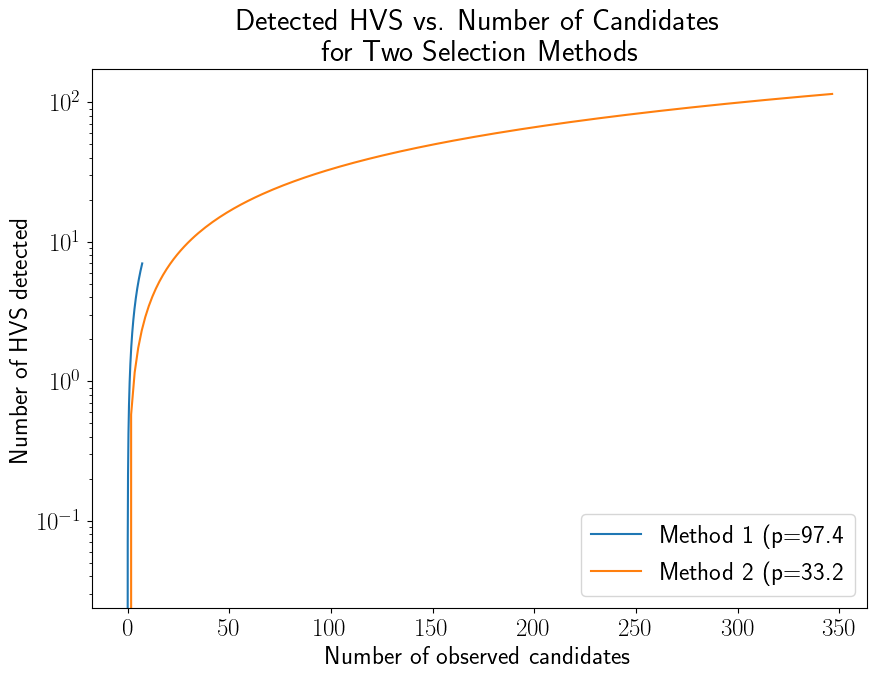

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# --- Selection methods ---
# Method 1:
c1 = 0.014   # completeness = 1.4%
p1 = 0.974   # purity       = 97.4%

# Method 2:
c2 = 0.23    # completeness = 23%
p2 = 0.332   # purity       = 33.2%

# Range of total actual HVS in the field:
T_values = np.linspace(0, 500, 200)  # from 0 up to ~700, for a smooth curve

# Compute number of HVS detected (y-axis) and number of candidates (x-axis)
detected_m1 = c1 * T_values          # c1 * T
candidates_m1 = detected_m1 / p1     # (c1 * T)/p1

detected_m2 = c2 * T_values          # c2 * T
candidates_m2 = detected_m2 / p2     # (c2 * T)/p2

# Create the plot
plt.figure()

# Plot Method 1
plt.plot(candidates_m1, detected_m1, label="Method 1 (p=97.4%, c=1.4%)")

# Plot Method 2
plt.plot(candidates_m2, detected_m2, label="Method 2 (p=33.2%, c=23%)")

plt.yscale('log')
# Label axes and show legend
plt.xlabel("Number of observed candidates")
plt.ylabel("Number of HVS detected")
plt.legend()
plt.title("Detected HVS vs. Number of Candidates\nfor Two Selection Methods")
plt.show()


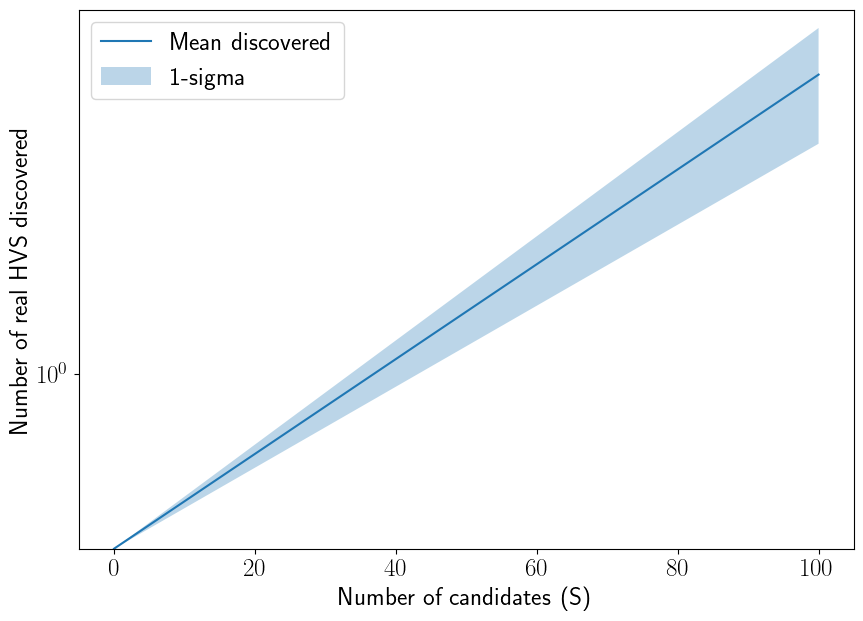

In [110]:
import numpy as np
import matplotlib.pyplot as plt

def discover_distribution(S, p, N_draws=10000):
    """
    Given S total candidates, each with a probability p of being a real HVS,
    do a Monte Carlo draw to find how many real HVS are actually in that sample,
    returning the distribution of 'counts'.
    """
    # If S is large, you could do a binomial each iteration:
    #   real_in_S = np.random.binomial(S, p, size=N_draws)
    # But if you want a 2-step approach (like sub-sampling, etc.), adapt as needed.

    return np.random.binomial(S, p, size=N_draws)

S_values = np.arange(0, 200, 100)  # or whatever range of #candidates you want
p = 0.05  # example: 5% of your candidates are truly HVS

means = []
lowerrs = []
upperrs = []

for S in S_values:
    counts = discover_distribution(S, p)
    means.append(np.mean(counts))
    # 1-sigma:
    lowerrs.append(np.percentile(counts, 16))
    upperrs.append(np.percentile(counts, 84))

plt.figure()
plt.plot(S_values, means, label="Mean discovered")
plt.fill_between(S_values, lowerrs, upperrs, alpha=0.3, label="1-sigma")
plt.xlabel("Number of candidates (S)")
plt.ylabel("Number of real HVS discovered")
plt.legend()
plt.ylim(1e-5, 8)
plt.yscale('symlog')
plt.show()


In [154]:
def var_sel(n_trial, purity, completeness, total_hvs=5):
    """
    Compute the variance of the number of selected objects in a sample of size n_trial
    with a given purity and completeness.
    """
    p_hvs = total_hvs*completeness/114 # expected number of HVS, p_hvs = N_hvs/N_total
    
    return np.sqrt(n_trial * p_hvs * (1 - p_hvs))

def expected_hvs_obs(n_obs, purity, completeness, total_hvs= 41):
    """
    Compute the expected number of HVS in a sample of size n_obs
    with a given purity and completeness.
    """
    p_hvs = total_hvs*completeness/114
    return n_obs * p_hvs





In [156]:
import numpy as np

def var_sel(n_trial, purity, completeness, total_hvs=5):
    """
    Returns the standard deviation of the number of real HVS
    in a random sample of size n_trial, 
    drawn from a candidate list whose purity = fraction of real HVS is 'purity'.

    NOTE: Despite the name 'var_sel', this function actually returns the
    STANDARD DEVIATION (sqrt of the variance), matching your original code style.

    Parameters
    ----------
    n_trial : int
        Size of the random sub-sample drawn from the candidate list.
    purity : float
        Fraction of the candidate list that are truly HVS (0 < purity < 1).
    completeness : float
        Not used in this formula if we're directly sampling from the candidate list.
    total_hvs : float or int
        Not used in this formula if we're directly sampling from the candidate list.

    Returns
    -------
    float
        Standard deviation of the number of real HVS in that sub-sample.
    """
    # Binomial SD = sqrt(n * p * (1 - p))
    return np.sqrt(n_trial * purity * (1. - purity))

def expected_hvs_obs_v3(n_obs, purity, completeness, total_hvs=5):
    """
    Returns the expected (mean) number of real HVS in a random sample of size n_obs,
    drawn from a candidate list with fraction 'purity' of real HVS.

    Parameters
    ----------
    n_obs : int
        Size of the random sub-sample drawn from the candidate list.
    purity : float
        Fraction of the candidate list that are truly HVS (0 < purity < 1).
    completeness : float
        Not used here if we assume we've already formed the candidate list.
    total_hvs : float or int
        Not used here if we assume we've already formed the candidate list.

    Returns
    -------
    float
        The expected (mean) number of real HVS in that sub-sample.
    """
    # Binomial mean = n * p
    return n_obs * purity


## Blue

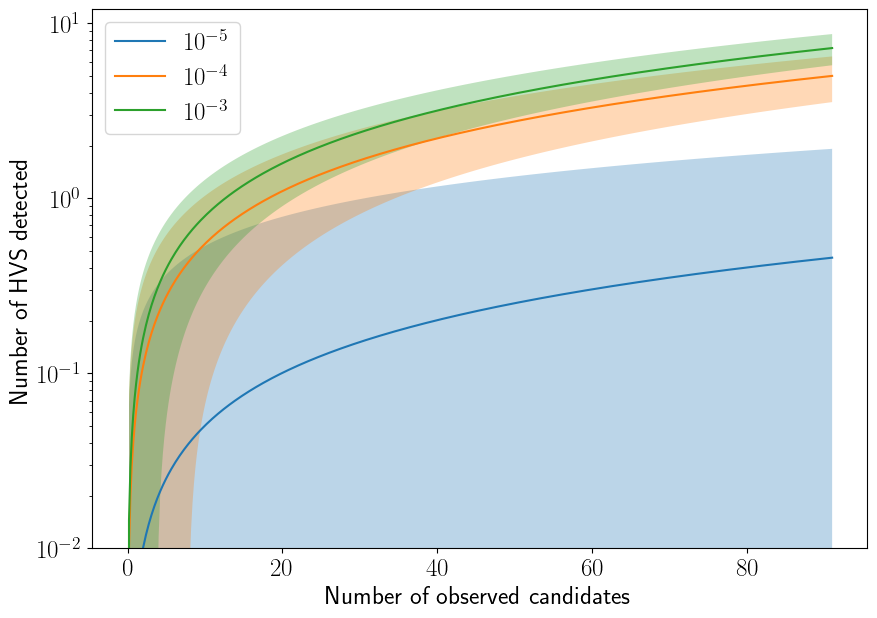

In [196]:
plt.figure()
# for 10^-5
x = np.linspace(0, 91, 500)
y = expected_hvs_obs(x, 0.976, 0.014, total_hvs=41)
plt.plot(x, y, label=r"$10^{-5}$")
# grey area for the variance
y1 = y - var_sel(x, 0.976, 0.014)
y2 = y + var_sel(x, 0.976, 0.014)
plt.fill_between(x, y1, y2, alpha=0.3)

# for 10^-4
y_2 = expected_hvs_obs(x, 0.976, 0.014, total_hvs=448)
plt.plot(x, y_2, label=r"$10^{-4}$")
# grey area for the variance
y1_2 = y_2 - var_sel(x, 0.976, 0.014, total_hvs=448)
y2_2 = y_2 + var_sel(x, 0.976, 0.014, total_hvs=448)
plt.fill_between(x, y1_2, y2_2, alpha=0.3)

# for 10^-3
y_3 = expected_hvs_obs(x, 0.976, 0.014, total_hvs=646)
plt.plot(x, y_3, label=r"$10^{-3}$")
# grey area for the variance
y1_3 = y_3 - var_sel(x, 0.976, 0.014, total_hvs=646)
y2_3 = y_3 + var_sel(x, 0.976, 0.014, total_hvs=646)
plt.fill_between(x, y1_3, y2_3, alpha=0.3)
plt.xlabel("Number of observed candidates")
plt.ylabel("Number of HVS detected")
plt.yscale('log')  
plt.ylim(1e-2, 1.2e1)
plt.legend()
plt.savefig('/Users/mncavieres/Documents/2024-2/HVS/Plots/eso_proposal/blue_selection.pdf')
plt.show()

## Red

In [190]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'sans-serif'
# The following line ensures that the LaTeX default sans-serif font is used 
# (i.e., Computer Modern Sans).
mpl.rcParams['text.latex.preamble'] = r'\renewcommand{\familydefault}{\sfdefault}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Computer Modern Sans']
mpl.rcParams['text.latex.preamble'] = r'\usepackage{cmbright}'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\renewcommand{\familydefault}{\sfdefault}'




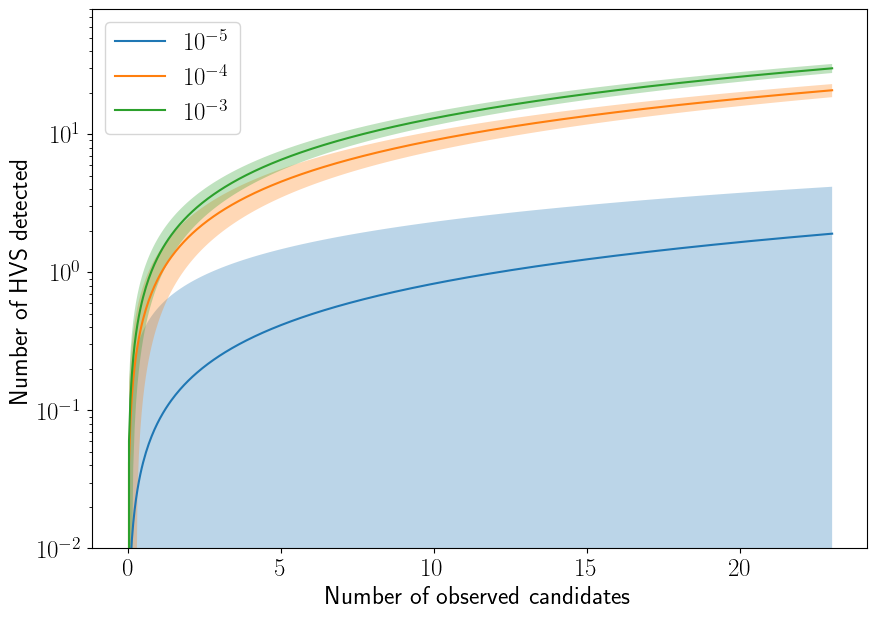

In [197]:
purity = 0.332
completeness = 0.23
plt.figure()
# for 10^-5
x = np.linspace(0, 23, 500)
y = expected_hvs_obs(x, purity, completeness, total_hvs=41)
plt.plot(x, y, label=r"$10^{-5}$")
# grey area for the variance
y1 = y - var_sel(x, purity, completeness)
y2 = y + var_sel(x, purity, completeness)
plt.fill_between(x, y1, y2, alpha=0.3)

# for 10^-4
y_2 = expected_hvs_obs(x, purity, completeness, total_hvs=448)
plt.plot(x, y_2, label=r"$10^{-4}$")
# grey area for the variance
y1_2 = y_2 - var_sel(x, purity, completeness, total_hvs=448)
y2_2 = y_2 + var_sel(x, purity, completeness, total_hvs=448)
plt.fill_between(x, y1_2, y2_2, alpha=0.3)

# for 10^-3
y_3 = expected_hvs_obs(x, purity, completeness, total_hvs=646)
plt.plot(x, y_3, label=r"$10^{-3}$")
# grey area for the variance
y1_3 = y_3 - var_sel(x, purity, completeness, total_hvs=646)
y2_3 = y_3 + var_sel(x, purity, completeness, total_hvs=646)
plt.fill_between(x, y1_3, y2_3, alpha=0.3)
plt.xlabel(r"Number of observed candidates")
plt.ylabel(r"Number of HVS detected")
plt.yscale('log')  
plt.ylim(1e-2, 0.8e2)
plt.legend()
plt.savefig('/Users/mncavieres/Documents/2024-2/HVS/Plots/eso_proposal/red_selection.pdf')
plt.show()